# WCM with Particle Swarm Optimization of parameters for KGE minimization

In [1]:
"""
c.massari - s.modanesi 08/11/2022
define WCM(PAR[i], data_in) 
#può essere usato con modello di suolo + WCM o WCM o modello di suolo
"""
import pyswarms as ps
import hydroeval as he
import numpy as np
import matplotlib.pyplot as plt

# Forward model for calibration

2022-11-09 15:46:07,685 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████|10/10, best_cost=0.206
2022-11-09 15:46:07,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.20640613373771766, best pos: [  0.11616432   0.18117494 -18.66040842  56.79874913]


[  0.11616432   0.18117494 -18.66040842  56.79874913]


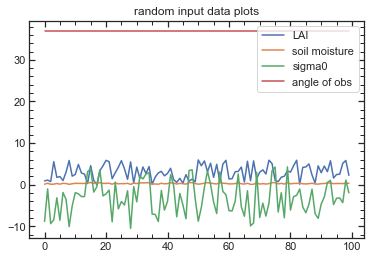

In [59]:
def WCM(PAR, data_in):

    A,B,C,D = PAR # parameters
    SM,LAI,t_deg,obs = data_in # input data
    theta = t_deg*np.pi/180. # angle of observation
    
    sig0s_dB = C+D*SM # define bare soil backscatter [dB]
    sig0s = 10**(sig0s_dB/10) # from dB to linear scale
    T2 = np.exp((-2*B*LAI)/np.cos(theta)) # two-way attenuation from the vegetation layer
    sig0v = A*LAI*np.cos(theta)*(1-T2) # define backscatter from the vegetation
    sig0_lin = T2*sig0s+sig0v
    sig0=10*np.log10(sig0_lin) # from linear scale to dB
    
    OUT=he.evaluator(he.kge, sig0, obs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return KGE # AT THE MOMENT THE OUTPUT IS THE KGE FOR MINIMIZATION OF IT

#----------------TRY an EXAMPLE with random timeseries
PAR=[0.4,0.4,-20,40] #some guess values of WCM Parameters
SM=np.random.uniform(low=0.05, high=0.5, size=(100,))
LAI=np.random.uniform(low=0, high=6, size=(100,))
t_deg = np.random.uniform(low=37, high=37, size=(100,))
obs = np.random.uniform(low=-20, high=-5, size=(100,))


plt.plot(LAI, label='LAI')
plt.plot(SM, label='soil moisture')
plt.plot(obs, label='sigma0')
plt.plot(t_deg, label='angle of obs')
plt.title('random input data plots')
plt.legend(loc='upper right')

data_in=[SM,LAI,t_deg,obs]
KGE = WCM(PAR, data_in)

#--------------START calibration (here using random timeseries)
bnds1 = (np.array([0, 0, -35, 15]), # min
         np.array([0.4, 0.4,-10,80])) # max
# from Modanesi_2022

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

def func0(PAR):
    global data_in
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        KGE = WCM(PAR[i], data_in)        
        err[i] = 1 - KGE
    return err


optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=4, options=options, bounds=bnds1)

cost, PARn = optimizer.optimize(func0, 10) #revise

#------------- model run validation
results = WCM(PARn, data_in)
print(PARn)

# Inverse model for SM estimation 

RMSE = 0.6912791067809456
R= [array([1.        , 0.06315343]), array([0.06315343, 1.        ])]


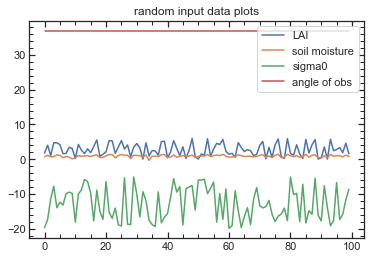

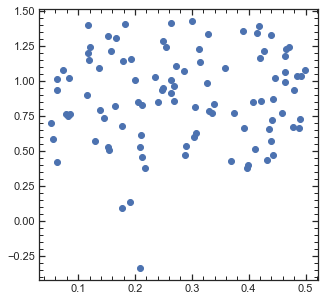

In [56]:
def SM_fromWCM(PAR, data_in):

    A,B,C,D = PAR # parameters
    LAI,t_deg,obs = data_in # input data
    theta = t_deg*np.pi/180. # angle of observation
    
    T2 = np.exp((-2*B*LAI)/np.cos(theta)) # two-way attenuation from the vegetation layer
    sig0v = A*LAI*np.cos(theta)*(1-T2) # define backscatter from the vegetation [lin]
    sig0s_lin = 1/T2*(abs(10**(obs/10)-sig0v))
    SM = 1/D*(10*np.log10(sig0s_lin)-C)

    return SM

#----------------retrieve the initial distribution
PAR=PARn
data_val=[LAI,t_deg,obs]
SM_retr=SM_fromWCM(PARn, data_val);

SM_RMSE=np.mean((SM_retr-SM)**2)**0.5; print('RMSE =', SM_RMSE)
CORR=np.corrcoef(SM_retr,SM); print('R=', list(CORR))

plt.plot(LAI, label='LAI')
plt.plot(SM_retr, label='soil moisture')
plt.plot(obs, label='sigma0')
plt.plot(t_deg, label='angle of obs')
plt.title('random input data plots')
plt.legend(loc='upper right')

plt.figure(figsize=(5,5))
plt.scatter(SM, SM_retr)
# plt.plot(abs(SM-SM_retr)/SM)